# Installation

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 4.4 MB/s 
     |████████████████████████████████| 3.5 MB 3.9 MB/s 
     |████████████████████████████████| 407 kB 3.9 MB/s 
     |████████████████████████████████| 45 kB 2.4 MB/s 


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Structure

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [4]:
in_feats=5
out_feats=2
nb_nodes=3

W=nn.Parameter(torch.zeros(size=(in_feats, out_feats)))
nn.init.xavier_uniform_(W.data, gain=1.414)

tensor([[-0.6560, -0.0150],
        [ 1.1341,  0.3668],
        [ 0.7691,  0.4723],
        [-0.6128,  0.8160],
        [ 0.6026,  1.1000]])

In [6]:
input=torch.rand(nb_nodes, in_feats)
h=torch.mm(input, W) # as input is 3 x 5, and 5 x 2, so output will be 3 x 2
N=h.size()[0]
print(h.shape)

torch.Size([3, 2])


# Attention Mechanism

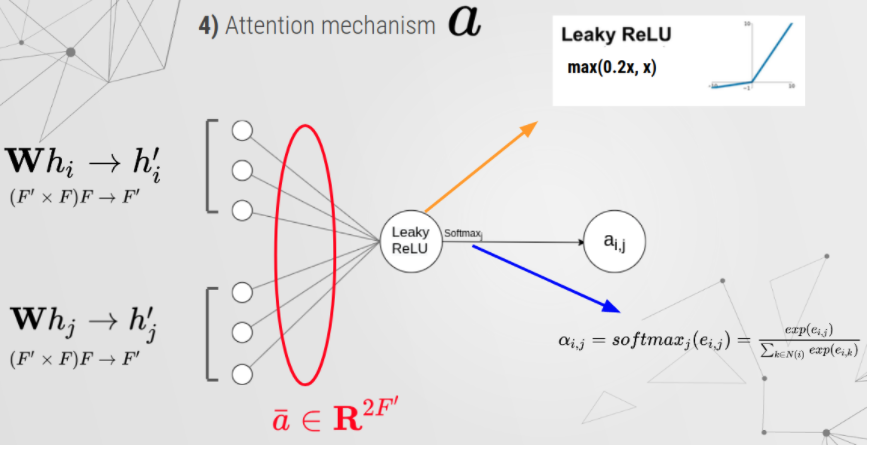

In [9]:
a= nn.Parameter(torch.zeros(size= (2*out_feats, 1)))
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

torch.Size([4, 1])


In [12]:
leakyrelu= nn.LeakyReLU(0.2)

In [15]:
h.shape

torch.Size([3, 2])

In [16]:
h.repeat(1, N).shape

torch.Size([3, 6])

In [18]:
a_input= torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1)
print(a_input.shape)
a_input=a_input.view(N, -1, 2 * out_feats)
print(a_input.shape)

torch.Size([9, 4])
torch.Size([3, 3, 4])


In [19]:
e= leakyrelu(torch.matmul(a_input, a))
print(e.shape)
e=e.squeeze(2)
print(e.shape)

torch.Size([3, 3, 1])
torch.Size([3, 3])


> Masked Attention

In [20]:
adj = torch.randint(2, (3,3))
adj.shape

torch.Size([3, 3])

In [21]:
zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)

torch.Size([3, 3])


In [22]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[1, 0, 1],
        [0, 1, 1],
        [1, 0, 0]]) 
 tensor([[1.1146, 1.8465, 2.0351],
        [1.1933, 1.9252, 2.1139],
        [2.0384, 2.7702, 2.9589]], grad_fn=<SqueezeBackward1>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[ 1.1146e+00, -9.0000e+15,  2.0351e+00],
        [-9.0000e+15,  1.9252e+00,  2.1139e+00],
        [ 2.0384e+00, -9.0000e+15, -9.0000e+15]], grad_fn=<SWhereBackward0>)

In [23]:
attention= F.softmax( attention, dim =1)
h_prime = torch.matmul(attention, h)

In [24]:
h_prime.shape

torch.Size([3, 2])

> **Implementing GAT layer, single headed**

In [25]:
F.elu??

In [26]:
class GAT(nn.Module):
  def __init__(self, in_features, out_features, dropout, alpha, concat = True):
    super(GAT, self).__init__()
    self.dropout       = dropout        # drop prob = 0.6
    self.in_features   = in_features    # 
    self.out_features  = out_features   # 
    self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
    self.concat        = concat         # concat = True for all layers except the output layer.

    # Xavier Initialization of Weights
    # Alternatively use weights_init to apply weights of choice 
    self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
    nn.init.xavier_uniform_(self.W.data, gain=1.414)
    
    self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
    nn.init.xavier_uniform_(self.a.data, gain=1.414)
    
    # LeakyReLU
    self.leakyrelu = nn.LeakyReLU(self.alpha)

  def forward(self, input, adj):
    # Linear Transformation
    h = torch.mm(input, self.W) # matrix multiplication
    N = h.size()[0]
    print(N)

    # Attention Mechanism
    a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
    e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

    # Masked Attention
    zero_vec  = -9e15*torch.ones_like(e)
    attention = torch.where(adj > 0, e, zero_vec)
    
    attention = F.softmax(attention, dim=1)
    attention = F.dropout(attention, self.dropout, training=self.training)
    h_prime   = torch.matmul(attention, h)

    if self.concat:
        return F.elu(h_prime)
    else:
        return h_prime

> Using GAT layers from PyG

In [4]:
from torch_geometric.data import download_url, extract_zip


In [5]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Processing...
Done!


Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


In [12]:
class GAT(torch.nn.Module):

  def __init__(self):
    super().__init__()

    self.hid= 8
    self.in_head = 8
    self.out_head = 1

    self.conv1= GATConv(dataset.num_features, self.hid, heads= self.in_head, dropout= 0.6)
    self.conv2= GATConv(self.hid * self.in_head, dataset.num_classes, concat = False, 
                        heads= self.out_head, dropout= 0.6)
    

  def forward(self, data):

    x, edge_index = data.x, data.edge_index
    x = F.dropout(x, p= 0.6, training=self.training)
    x=self.conv1(x, edge_index)
    x=F.elu(x)
    x= F.dropout(x, p=0.6, training=self.training)
    x= self.conv2(x, edge_index)

    return F.log_softmax(x, dim=1)


                 

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()
    
    

tensor(1.9442, grad_fn=<NllLossBackward0>)


In [14]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8130
